This notebook, which serves as the preliminary stage of model development, supports text/data cleaning and exploration procedures. This includes stemming, stop-word analysis, tockenization, special characters, collocation analysis and so forth.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import nltk
import re
import gc
import pickle
import os
from sklearn import decomposition
from sklearn.model_selection import train_test_split
import seaborn
import matplotlib.pyplot as plt
import json

In [2]:
econdata = pd.read_csv("./data/economic-newstext-data.csv", encoding="latin-1", engine='python', header=0)
econdata.shape

(5015, 19)

<h2> Text/Data Cleaning </h2>

In [3]:
#Recognize columns with high-null values (beyond 50% threshold) for dropping courtesy extensive manipulation
nulls = econdata.apply(lambda s: sum(s.isnull())/len(econdata))
print(nulls[nulls>0.5])
econdata.drop(nulls[nulls>0.5].index.values, axis=1, inplace=True)

orig__golden       0.996610
positivity_gold    0.993021
relevance_gold     0.988634
dtype: float64


In [4]:
econdata.drop(econdata.loc[econdata.relevance=="not sure"].index, inplace=True)
econdata['relev'] = econdata['relevance'].apply(lambda s: 1 if s=="yes" else 0)

In [5]:
econdata.drop(['articleid', 'date', 'lineid', 'previous_sentence', 'next_sentence', '_unit_id', '_golden',
              '_unit_state'], axis=1, inplace=True)
econdata.drop(econdata[econdata.text.isnull()].index, inplace=True)

In [6]:
econdata.headline.values[0], econdata.text.values[0]

('Nasdaq Index Falls 1.7% But Dow Stocks Are Up: Nasdaq Index Falls 1.7%, But Dow Stocks Move Higher',
 'The Nasdaq composite index, home of technology companies large and small, fell 1.7 percent even as the Dow Jones industrial average rose 20.81 points, to 3,342.99.')

In [7]:
#Text Cleaning: Removal special characters, case removal, stemming
def ascii_correction(s):
    s = s.encode('ascii', 'ignore').decode("utf-8").replace('\t', " ").replace("\\'", " ")
    s = re.sub("[^a-zA-Z0-9.,%']", " ", s).replace("  ", " ").replace(",","")
    return s.lower().replace("u.s.", "usa").replace("u.s", "usa") #To not interfere with period_correction
#Period correction: cleaner separation of words, unless period used as decimal point
def period_correction(s):
    potential = [pos for pos, char in enumerate(s) if char=="." and pos!=(len(s)-1)]
    num = ['0','1','2','3','4','5','6','7','8','9','10']
    error = [pos for pos in potential if s[pos-1] not in num or s[pos+1] not in num]
    if len(error)==0: return s
    def recursive(arr):
        if len(arr)==1: return " . "+s[arr[0]+1:]
        else: return " . "+s[arr[0]+1:arr[1]] + recursive(arr[1:])
    finalstr = s[:error[0]] + recursive(error)
    return finalstr.replace("  "," ")
for col in ['headline', 'text']: econdata[col]=econdata[col].apply(lambda s: period_correction(ascii_correction(s)))

In [8]:
econdata.headline.values[0], econdata.text.values[0]

('nasdaq index falls 1.7% but dow stocks are up nasdaq index falls 1.7% but dow stocks move higher',
 'the nasdaq composite index home of technology companies large and small fell 1.7 percent even as the dow jones industrial average rose 20.81 points to 3342.99.')

<h2> Text Exploration </h2>

In [9]:
#Word Frequency Overall and across Relevance
head = econdata.headline.apply(lambda s: s.split()).values
#Monoid flattening techniques, not suitable for production but theoretically elegant
headrel = sum(head[econdata.relevance==1], [])
headnotrel = sum(head[econdata.relevance==0], [])
head = [word for case in head for word in case]
text = econdata.text.apply(lambda s: s.split()).values
textrel = sum(text[econdata.relevance==1], [])
textnotrel = sum(text[econdata.relevance==0], [])
text = [word for case in text for word in case]

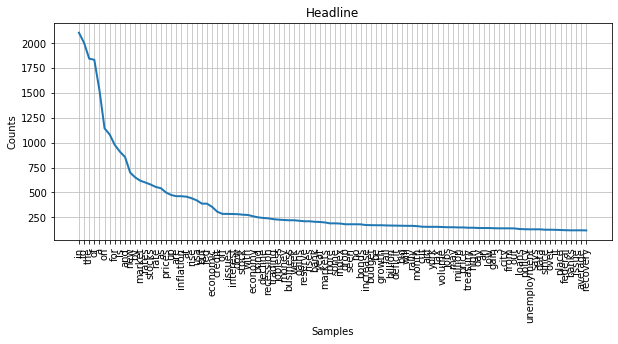

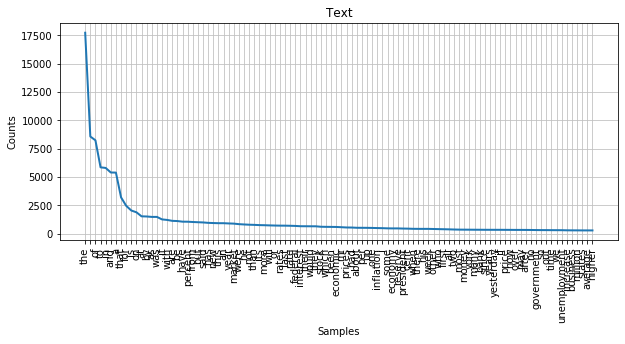

In [10]:
words = [head, text]
titles = ["Headline", "Text"]
for i in range(len(titles)):
    plt.figure(figsize=(10,4))
    plt.title(titles[i])
    nltk.probability.FreqDist(words[i]).plot(100)

In [11]:
# Collocations and Concordance
sas = [nltk.Text(i) for i in words]
for i in range(len(titles)):
    print(titles[i])
    print('; '.join(sas[i].collocation_list()))

Headline
new york; market place; interest rates; credit markets; economic scene; jobless rate; short term; federal reserve; money supply; san francisco; wall street; producer prices; odd lot; mutual funds; lot transactions; bond prices; kansas city; lows odd; long term; francisco dallas
Text
per cent; federal reserve; interest rates; new york; united states; stock market; wall street; dow jones; short term; long term; last week; jones industrial; industrial average; vice president; money supply; reserve board; last year; real estate; stock exchange; white house


Headline


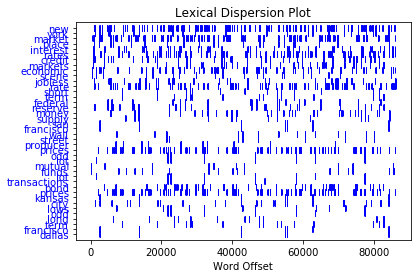

Text


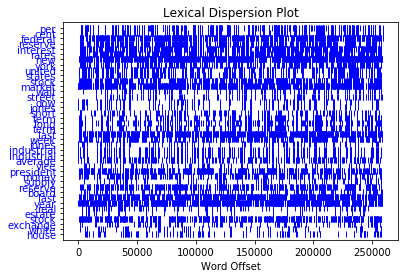

In [12]:
#Dispersion plots
#These dispersion plots reveal information for all our articles combined together. Hence, even though
#the "dispersion" across articles is not insightful, its implications on frequency is
#Bigrams from our collocation analysis also seem to appear at similar points through articles, as needed
for i in range(len(titles)):
    print(titles[i])
    sas[i].dispersion_plot([word for bigram in sas[i].collocation_list() for word in bigram.split()])

<h2> Dataset Separation </h2>

We would be building a two-layered model - a classification to predict relevance, and a classification/regression to predict extent/level of positivity for the relevant articles from first layer. The relevant splits into train-test sets are made, to proceed to (i) traditional NLP (trigams, SVD) and (ii) advanced language models (LSTM, BERT)

In [13]:
econdata['headline'] = econdata['headline'].apply(lambda s: s+"." if s[-1]!="." else s)
econdata['text'] = econdata['headline'] + " " + econdata['text']
econdata['text'] = econdata['text'].apply(lambda s: s+"." if s[-1]!="." else s)
econdata.drop(['_trusted_judgments', 'headline', '_last_judgment_at', 'relevance:confidence'], axis=1, inplace=True)

In [14]:
relX, relY = econdata['text'], econdata['relev']
posdata = econdata[econdata['relev']==1]
posX, posY = posdata["text"], posdata[["positivity", "positivity:confidence"]]

In [15]:
reltrainX, reltestX, reltrainY, reltestY = train_test_split(relX, relY, random_state=1)
postrainX, postestX, postrainY, postestY = train_test_split(posX, posY, random_state=1)

In [16]:
print(reltrainX.shape, reltestX.shape, reltrainY.shape, reltestY.shape)
print(postrainX.shape, postestX.shape, postrainY.shape, postestY.shape)

(3720,) (1240,) (3720,) (1240,)
(2175,) (726,) (2175, 2) (726, 2)


In [17]:
models = ["relevance", "positivity"]
files = ["trainX", "testX", "trainY", "testY"]
data = [[reltrainX, reltestX, reltrainY, reltestY], [postrainX, postestX, postrainY, postestY]]
for mdl in range(len(models)):
    for fl in range(len(files)):
        pickle.dump(data[mdl][fl].reset_index(drop=True), open("./data/"+models[mdl]+"_"+files[fl]+".pkl", "wb"))